In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [19]:
import numpy as np
import os
import urllib

In [3]:
def geturl_legacy(ra, dec, size=240, band='r', layer='dr8-resid'):
    
    assert band in ['g', 'r', 'z']
    assert layer in ['dr8', 'dr8-resid', 'dr8-model']

    url = ("http://legacysurvey.org/viewer/fits-cutout/?ra={}&dec={}&layer={}&pixscale=0.27&bands={}&size={}").format(ra, dec, layer, band, size)
    return url

In [4]:
def clear_on_fail_(name, dir_path):
    for band in ['g', 'r', 'z']:
        for layer in ['dr8', 'dr8-resid', 'dr8-model']:
            output_image='{}/{}_{}_{}.fits'.format(dir_path, name, layer, band)
            try:
                os.remove(output_image)
            except:
                pass

def load_legacy_all(name=None, ra=None, dec=None, size=None, save_to=None):
    if not os.path.isdir(save_to):
        os.mkdir(save_to)
    
    for band in ['g', 'r', 'z']:
        for layer in ['dr8', 'dr8-resid', 'dr8-model']:
            try:
                fitsurl = geturl_legacy(ra, dec, band=band, size=size, layer=layer)
                output_image='{}/{}_{}_{}.fits'.format(save_to, name, layer, band)
                urllib.request.urlretrieve(fitsurl, output_image)
                if os.path.getsize(output_image)/1024 < 3:  # empirical threshold
                    clear_on_fail_(name, save_to)
                    break;break
            except Exception as e:
                clear_on_fail_(name, save_to)
                raise e

Example:

In [14]:
%%time
load_legacy_all(name='1353_35_0_line6550', ra=123.7185078325, dec=1.5649554293, size=400, save_to='./fits/')

CPU times: user 70.1 ms, sys: 64.8 ms, total: 135 ms
Wall time: 26.9 s


In [2]:
coords = {'NGC628' : (24.173946,15.783662),
          'NGC2403': (114.214167,65.602556),
          'NGC3344': (160.879792,24.922222),
          'NGC3893': (177.159125,48.710833),
          'NGC5371': (208.916425,40.461759),
          'NGC5676': (218.195194,49.457903)
         }

In [ ]:
for galname in coords.keys():
    ra,dec = coords[galname]
    load_legacy_all(name=galname, ra=ra, dec=dec, size=800, save_to='./fits/')

In [ ]:
for galname in ['NGC2403']:
    ra,dec = coords[galname]
    load_legacy_all(name=galname, ra=ra, dec=dec, size=3800, save_to='./fits/')

In [118]:
for galname in ['NGC628']:
    ra,dec = coords[galname]
    load_legacy_all(name=galname, ra=ra, dec=dec, size=1800, save_to='./fits/')

In [5]:
import pyfits
from scipy.ndimage import rotate
from astropy.visualization import ZScaleInterval, PercentileInterval

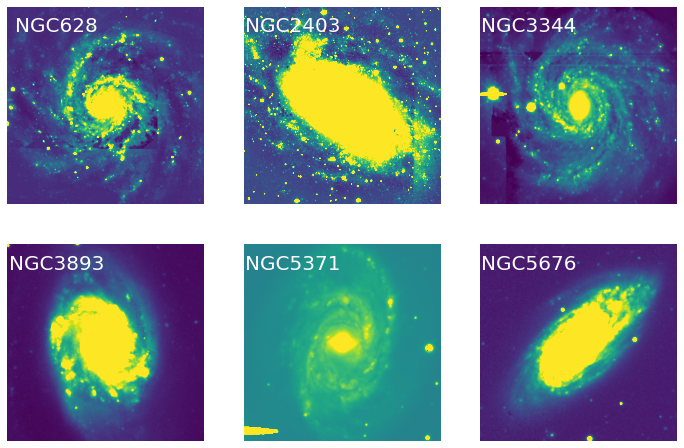

In [119]:
fig, axes = plt.subplots(figsize=[12,8], ncols=3, nrows=2)
axes = axes.flatten()

for ind, name in enumerate(coords.keys()):
    hdulist = pyfits.open(f'./fits/{name}_dr8_g.fits')
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data
    
    ax = axes[ind]
    lims = ZScaleInterval().get_limits(img_data_raw)
    ax.imshow(img_data_raw, vmin=lims[0], vmax=lims[1])
    
    ax.text(0.25, 0.9, name,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=20,
           color='w')
    ax.axis('off')
    
plt.show()

In [120]:
posargs = '''NGC628 & $7\deg$ & $20\deg$ & 8.6 & Marchuk et al. (2018)\\
NGC2403 & $60\deg$ & $124.6\deg$ & 3.16 & Berg et al. (2013)\\
NGC3344 & $25\deg$ & $155\deg$ & 6.9 & Meidt et al. (2009)\\
NGC3893 & $49\deg$ & $343\deg$ & 15.5 & Font et al. (2019)\\
NGC5371 & $48\deg$ & $0\deg$ & 37.8 & Fathi et al. (2009)\\
NGC5676 & $63\deg$ & $223\deg$ & 34.7 & Salak et al. (2019)\\'''

posargs = [_.split(' & ') for _ in posargs.split('\n')]
posargs = {_[0] : (float(_[1].replace('\deg$', '').replace('$', '')), float(_[2].replace('\deg$', '').replace('$', ''))) for _ in posargs}

In [121]:
posargs

{'NGC628': (7.0, 20.0),
 'NGC2403': (60.0, 124.6),
 'NGC3344': (25.0, 155.0),
 'NGC3893': (49.0, 343.0),
 'NGC5371': (48.0, 0.0),
 'NGC5676': (63.0, 223.0)}

In [122]:
import rotima

In [123]:
for name in posargs.keys():
    
    incl,pa = posargs[name]
    
    hdulist = pyfits.open(f'./fits/{name}_dr8_g.fits')
    hdr = hdulist[0].header
    img_data_raw = hdulist[0].data

    xcen = float(hdr['CRPIX1'])
    ycen = float(hdr['CRPIX2'])
    print(name, xcen, ycen)

    rotima.cdeproject(infile=f'./fits/{name}_dr8_g.fits',
                 outfile=f'./fits/{name}_dr8_g_deproject.fits',
                 yCen=ycen,
                 xCen=xcen,
                 incl=incl,
                 posang=-pa,
                 workHDU=1)

NGC628 900.5 900.5
NGC2403 1500.5 1500.5
NGC3344 400.5 400.5
NGC3893 400.5 400.5
NGC5371 400.5 400.5
NGC5676 400.5 400.5


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log2
  # Remove the CWD from sys.path while we load stuff.
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log2
  # This is added back by InteractiveShellApp.init_path()


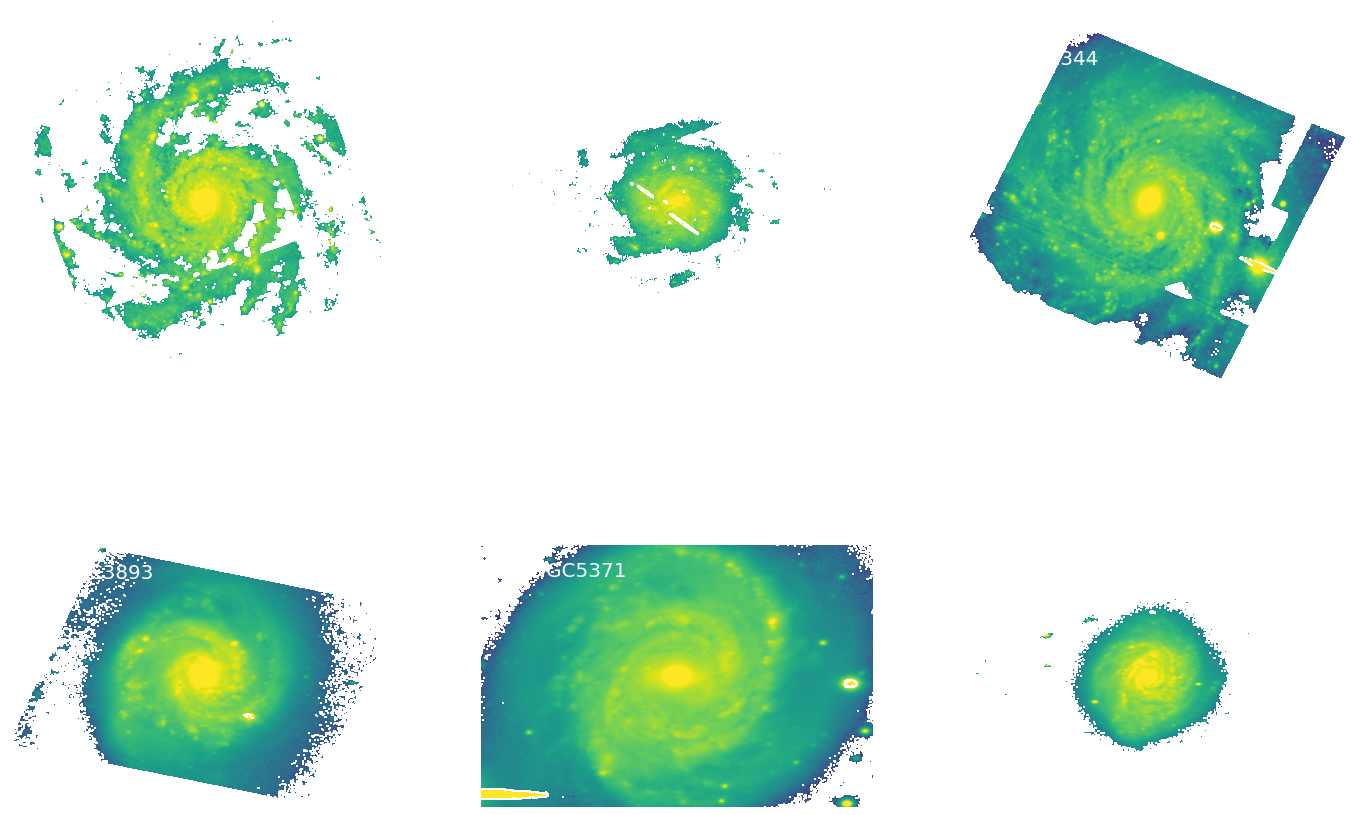

In [124]:
fig, axes = plt.subplots(figsize=[24,16], ncols=3, nrows=2)
axes = axes.flatten()

for ind, name in enumerate(coords.keys()):
    hdulist = pyfits.open(f'./fits/{name}_dr8_g_deproject.fits')
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data
    
    ax = axes[ind]
    lims = PercentileInterval(98).get_limits(np.log2(img_data_raw))
    ax.imshow(np.log2(img_data_raw), vmin=lims[0], vmax=lims[1])
    
    ax.text(0.25, 0.9, name,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=20,
           color='w')
    ax.axis('off')
    
plt.show()

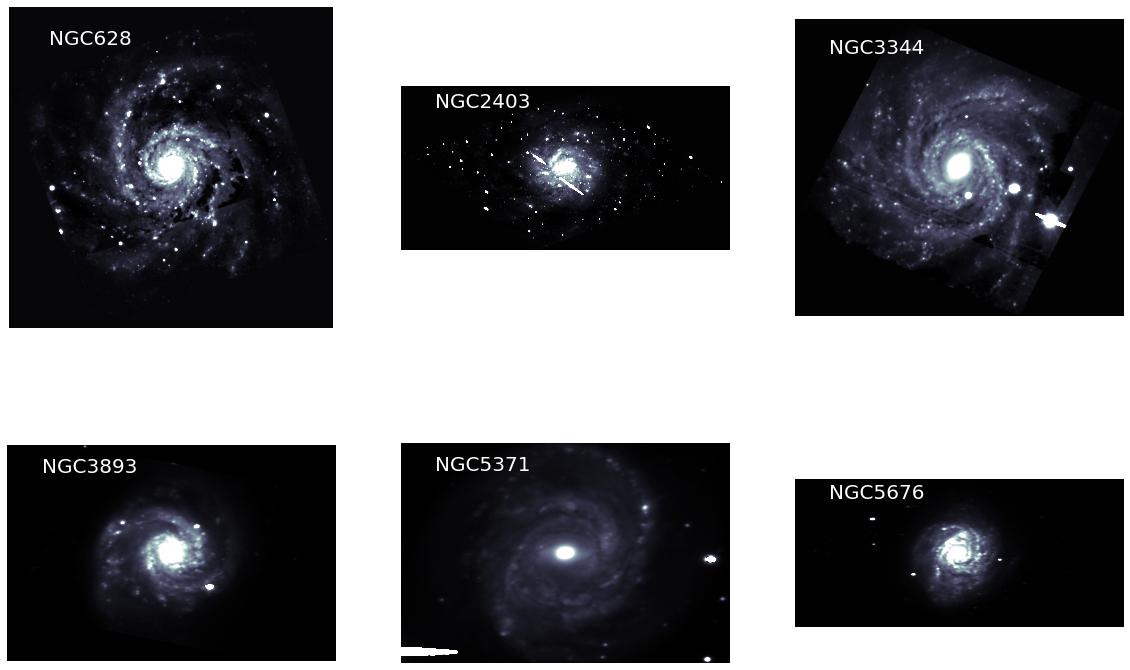

In [125]:
fig, axes = plt.subplots(figsize=[20,13], ncols=3, nrows=2)
axes = axes.flatten()

for ind, name in enumerate(coords.keys()):
    hdulist = pyfits.open(f'./fits/{name}_dr8_g_deproject.fits')
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data
       
    ax = axes[ind]
    lims = PercentileInterval(98.5).get_limits(img_data_raw)
    ax.imshow(img_data_raw, vmin=lims[0], vmax=lims[1], cmap=cm.bone)
    
    ax.text(0.25, 0.9, name,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=20,
           color='w')
    ax.axis('off')
    
plt.show()

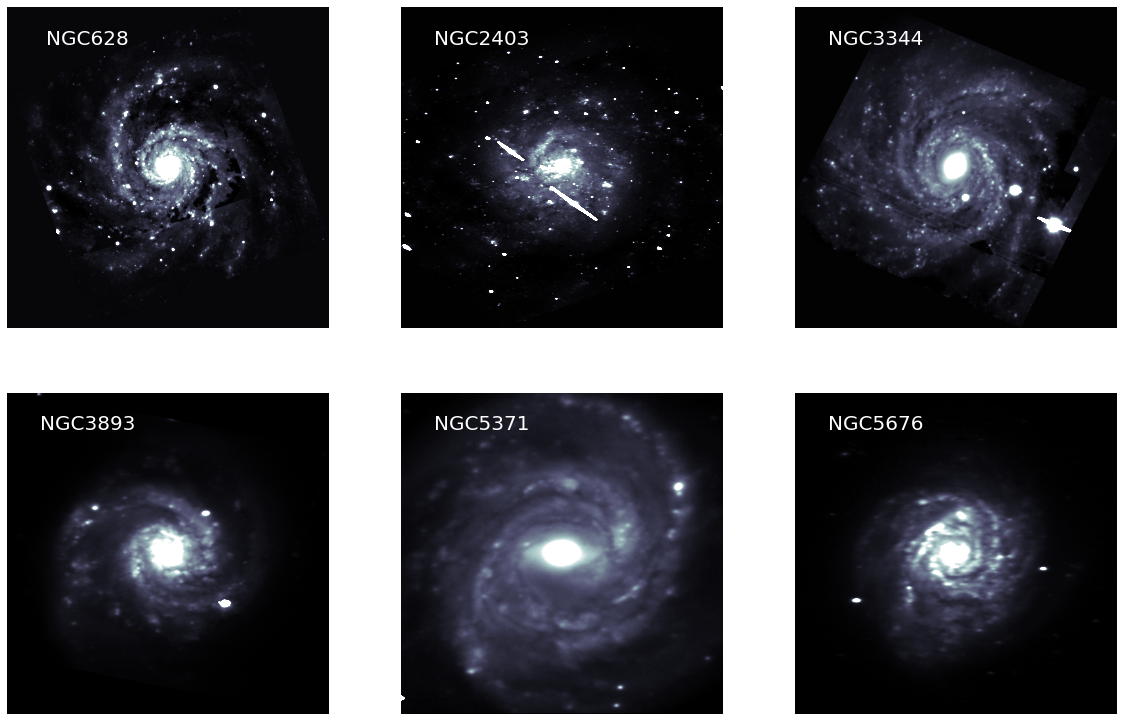

In [127]:
fig, axes = plt.subplots(figsize=[20,13], ncols=3, nrows=2)
axes = axes.flatten()

for ind, name in enumerate(coords.keys()):
    hdulist = pyfits.open(f'./fits/{name}_dr8_g_deproject.fits')
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data

    xl,yl = img_data_raw.shape
    x0,y0 = int(xl/2), int(yl/2)
    size = min(x0,y0)
    img_data_raw = img_data_raw[x0-size:x0+size, y0-size:y0+size]
    
    ax = axes[ind]
    lims = PercentileInterval(98.5).get_limits(img_data_raw)
    ax.imshow(img_data_raw, vmin=lims[0], vmax=lims[1], cmap=cm.bone)
    
    ax.text(0.25, 0.9, name,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=20,
           color='w')
    ax.axis('off')

plt.savefig('dataplot.png', bbox_inches='tight')
plt.show()



In [6]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
info_by_galaxy = load_obj('/mnt/sdb2/science/spirals/fourier-spiral-masks/data/cr/info_by_galaxy')

In [8]:
dists = '''2903 8.83
3184 8.7
3344 6.1
5371 34.8
3893 18.6
3938 17
3992 17
6946 10.1
7793 3.1
628 9.7
5457 7.0
2403 3.2'''

In [9]:
dists = dists.split('\n')
dists = {'NGC'+l.split(' ')[0] : float(l.split(' ')[1]) for l in dists}

In [10]:
dists

{'NGC2903': 8.83,
 'NGC3184': 8.7,
 'NGC3344': 6.1,
 'NGC5371': 34.8,
 'NGC3893': 18.6,
 'NGC3938': 17.0,
 'NGC3992': 17.0,
 'NGC6946': 10.1,
 'NGC7793': 3.1,
 'NGC628': 9.7,
 'NGC5457': 7.0,
 'NGC2403': 3.2}

In [11]:
from astropy import units as u

theta = 1*u.arcsec
d_A = 8.83*u.Mpc

theta_radian = theta * np.pi / 180 / 3600

# arc length = radius * angle
distance_Mpc = d_A * theta_radian

print(distance_Mpc) # 3.3846475 Mpc

4.280904804197203e-05 arcsec Mpc


In [12]:
scales = {}
for k in dists:
    theta = 1*u.arcsec
    d_A = dists[k]*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scales[k] = distance_Mpc.value*1000. #kpc/arcsec

In [13]:
scales

{'NGC2903': 0.042809048041972025,
 'NGC3184': 0.04217879025652963,
 'NGC3344': 0.029573634547681693,
 'NGC5371': 0.16871516102611853,
 'NGC3893': 0.0901753446863737,
 'NGC3938': 0.08241832578862111,
 'NGC3992': 0.08241832578862111,
 'NGC6946': 0.048966181792063135,
 'NGC7793': 0.015029224114395615,
 'NGC628': 0.047026927067624985,
 'NGC5457': 0.033936957677667516,
 'NGC2403': 0.015514037795505153}

In [14]:
# def epic_freq(vel_poly, R, dR):
#     return sqrt(2.) * vel_poly(R) / R * np.sqrt(1 + R * vel_poly.deriv()(R) / vel_poly(R) / dR)


def epic_freq(vel_poly, R, dR):
    return sqrt(2.) * vel_poly(R) / R

In [15]:
r25s = load_obj('/mnt/sdb2/science/spirals/CR_Olya/vel_curves/disc_r25_sizes')

In [16]:
import pandas as pd
df = pd.read_csv('/mnt/sdb2/science/spirals/CR_Olya/vel_curves/total_crs.csv', index_col=0)
df.sample(5)

name             method    bar     kind      bands  \
1127  NGC3059              morph  False  stellar    optical   
1006  NGC0289              model  False  stellar     H-band   
1036  NGC4995              model  False  stellar     H-band   
1303  NGC4293                T-W  False      ISM  CO,Halpha   
810   NGC4151  potential-density  False  stellar     H-band   

                                                   link  \
1127  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   
1006                https://arxiv.org/pdf/0806.0471.pdf   
1036                https://arxiv.org/pdf/0806.0471.pdf   
1303               https://arxiv.org/pdf/2102.01091.pdf   
810   https://iopscience.iop.org/article/10.1088/006...   

                           paper_name         cr  err_cr_l  err_cr_r  cr_l  \
1127     Elmegreen & Elmegreen (1995)  58.200000  4.800000  4.800000  53.4   
1006  Rautiainen & Laurikainen (2008)  61.000000  9.500000  9.500000  51.5   
1036  Rautiainen & Laurikainen (2008)  64.200000  5.500000  5.500000  58.7   
1303           Williams et al. (2021)   2.256021  2.256021  2.256021   0.0   
810               Buta & Zhang (2009)  69.800000  0.000000  0.000000  69.8   

           cr_r  err_range   altname         r25  
1127  63.000000   9.600000  NGC 3059  113.794495  
1006  70.500000  19.000000  NGC 0289  100.721284  
1036  69.700000  11.000000  NGC 4995   72.798303  
1303   4.512043   4.512043  NGC 4293  187.120451  
810   69.800000   0.000000  NGC 4151   86.321952

In [17]:
df[df['name']=='NGC5676']

name             method    bar     kind        bands  \
17    NGC5676                F-B  False      ISM   Halpha, HI   
18    NGC5676                F-B  False      ISM   Halpha, HI   
19    NGC5676                F-B  False      ISM   Halpha, HI   
20    NGC5676                F-B  False      ISM   Halpha, HI   
931   NGC5676  potential-density  False  stellar       H-band   
932   NGC5676  potential-density  False  stellar       H-band   
933   NGC5676  potential-density  False  stellar       H-band   
1233  NGC5676              model  False     both  NIR, Halpha   

                                                   link           paper_name  \
17                                                  NaN            F-B works   
18                                                  NaN            F-B works   
19                                                  NaN            F-B works   
20                                                  NaN            F-B works   
931   https://iopscience.iop.org/article/10.1088/006...  Buta & Zhang (2009)   
932   https://iopscience.iop.org/article/10.1088/006...  Buta & Zhang (2009)   
933   https://iopscience.iop.org/article/10.1088/006...  Buta & Zhang (2009)   
1233         https://arxiv.org/pdf/astro-ph/0212290.pdf  Kranz et al. (2003)   

             cr   err_cr_l  err_cr_r       cr_l       cr_r  err_range  \
17    18.400000   1.900000  1.900000  16.500000  20.300000   3.800000   
18    32.100000   1.700000  1.700000  30.400000  33.800000   3.400000   
19    54.400000   2.400000  2.400000  52.000000  56.800000   4.800000   
20    76.500000   4.600000  4.600000  71.900000  81.100000   9.200000   
931   23.200000   0.000000  0.000000  23.200000  23.200000   0.000000   
932   38.200000   0.000000  0.000000  38.200000  38.200000   0.000000   
933   61.200000   0.000000  0.000000  61.200000  61.200000   0.000000   
1233  68.754935  12.500897  6.250449  56.254038  75.005384  18.751346   

       altname        r25  
17    NGC 5676  107.67658  
18    NGC 5676  107.67658  
19    NGC 5676  107.67658  
20    NGC 5676  107.67658  
931   NGC 5676  107.67658  
932   NGC 5676  107.67658  
933   NGC 5676  107.67658  
1233  NGC 5676  107.67658

NGC2403 SPARC arcsec
NGC2403 THINGS arcsec
NGC3344  kpc
NGC3893 SV89 kpc


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_laun

NGC5676 WHISP arcsec
NGC628 Ts kpc
NGC5371 Sa96 kpc


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in double_scalars


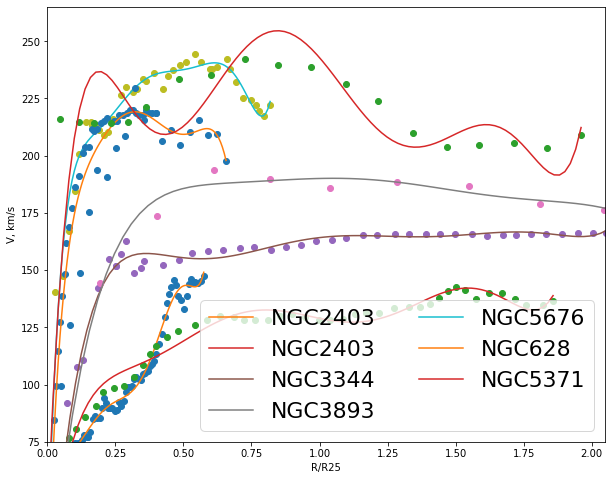

In [20]:
# d_path = './vel_curves/data/'
d_path = '/mnt/sdb2/science/spirals/CR_Olya/vel_curves/comb_vel_curves/'
ffnames = os.listdir(d_path)

vel_data = {}

fig = plt.figure(figsize=[10,8])
ax = plt.gca()

for fname in ffnames[2:]:
# for fname in ['NGC5676_WHISP_arcsec.data']:
    if '.png' in fname:
        continue
        
    if fname == 'Be87_NGC5371_kpc.data':
        continue
    
#     print('='*50)
#     print(fname)
    data = np.genfromtxt(d_path + fname, dtype=np.float, delimiter=',')
    if type(data[0])==np.float64:
        data = np.genfromtxt(d_path + fname, dtype=np.float, delimiter=' ')
    
    
   
    tmps = fname.replace('.data', '').replace('.dat', '').split('_')
    if len(tmps) == 2:
        name, units = tmps
        name2 = ''
    elif tmps[0].startswith('UGC') or tmps[0].startswith('NGC'):
        name, name2, units = tmps
    else:
        name2, name, units = tmps
    
    if name not in list(coords.keys()) and name2 not in coords.keys():
        continue
        
    print(name, name2, units)
    if name  == 'NGC2403' and name2 != 'THINGS':
        data = np.genfromtxt(d_path + fname, dtype=np.float, delimiter='  ')
    
    if units == 'kpc':
        data[:,0] = data[:,0]/scales[name]
        units = 'arcsec'
    
    if units == 'arcmin':
        data[:,0] = data[:,0]*60.
        units = 'arcsec'
    
    
    #correct systemic velocity in several cases, ssee Appendix
    if name == 'UGC6263':
        data[:,1] = data[:,1]+58.
    if name == 'UGC6778':
        data[:,1] = data[:,1]+14.
    if name == 'UGC5557':
        data[:,1] = data[:,1]+13.
    if name == 'NGC0753':
        data[:,1] = data[:,1]+35.
    if name == 'NGC5676':
        data[:,1] = data[:,1]+40.
        tmp = '''0.8011099915759701, 59.92633091623861
                3.06734279248775, 140.62370955220433
                6.303166449183209, 147.6107100972896
                8.481855271634089, 167.24616375679295
                11.015675327464066, 184.58565269817154
                12.472539270907333, 200.74825324986375
                15.359838786937758, 214.63966568110868
                17.15201268561802, 214.6809600105713
                17.867230471911597, 213.5453659503478
                19.30096959085577, 213.57840141391785
                20.372970383706928, 211.298954427578
                22.520275515766173, 209.04428403891575
                23.955666407888856, 210.2294312944947
                26.11453395219769, 216.03954344989347
                28.996878148692616, 226.47462050511228
                31.152442146644404, 229.98050907649372
                34.01661683817579, 227.7423564196165
                35.452007730298504, 228.92750367519534
                37.9676582811648, 233.593762904478
                39.04131084719444, 232.46642771014683
                42.2721791843544, 235.99709287920587
                45.84661634264384, 229.1670107860789
                47.64704910721659, 234.9688640755851
                49.800961331989896, 237.32264085495774
                52.67174311623526, 239.69293536611553
                54.82400356783006, 240.89460035347952
                58.41330668472605, 244.433524388431
                60.917394823342846, 241.03500107365267
                64.49678730116779, 237.6612543565517
                65.2136568606399, 237.67777208833684
                67.00748253249861, 238.87117820980814
                70.95522042913063, 242.4183611106523
                72.38235245536083, 237.84294940618759
                74.52470226788455, 232.13194364149922
                77.3822698667019, 225.2853438165871
                80.60653111114777, 224.20756181761112
                82.39540146347105, 221.94463256305653
                83.8258370360582, 219.67344444260914
                85.61470738838142, 217.41051518805443
                88.1303579392478, 222.0767744173371'''
        
        tmp = [[float(_.split(',')[0]), float(_.split(',')[1])] for _ in tmp.split('\n')]
#         data = np.concatenate([data, np.array(tmp)])
        data = np.array(tmp) #we use Halpha rot map instead - this is correct, see Appendix notes (Valeria not get it perfectly accurate)
        
        
    if name == 'NGC7741':
        data[:,1] = data[:,1]+4.
    if name  == 'NGC628':
        tmp = '''4.94637079738348, 47.29018716149051
        14.743295929425287, 99.19343270602502
        25.245004376178798, 126.1217810431331
        35.170917518275175, 148.92721983210265
        44.86395743283603, 175.61210470105823
        54.56103172477478, 193.56760551858002
        64.84544412331299, 190.6702781815268
        74.89160412447846, 203.29157565970476
        84.71015800190736, 208.39562337294123
        94.98336379661806, 229.74658506764868
        105.04196312803208, 215.45228172057233
        124.91900427083672, 206.50450897705
        134.3910499579192, 211.3656535523253
        144.90833558399297, 204.58888013528613
        154.9577455002684, 210.1781737942535
        164.77618731165902, 215.52470439780757
        175.17770872019463, 209.23275667885574
        184.8829638329275, 209.48700650319222
        194.70925026699734, 197.85973478451382'''
        
        tmp = [[float(_.split(',')[0]), float(_.split(',')[1])] for _ in tmp.split('\n')]
        data = np.concatenate([data, np.array(tmp)]) 
        
    
    r25  = df[df['name'] == name]['r25'].values[0]
    
    plt.plot(np.abs(data[:,0])/r25, np.abs(data[:,1]), 'o')
    plt.ylim(0)
#     plt.title(name)
#     plt.xlabel(f'R, {units}')
    
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
    
    points = np.linspace(min(rad), max(rad), 100)
    velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    
    line = plt.plot(points/r25, velocity_approx(points), label=name)
    
    dR = (max(rad) - min(rad)) / 20
    kappa = [epic_freq(velocity_approx, r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
 
    
plt.xlabel('R/R25')
plt.ylabel('V, km/s')
plt.ylim(75,265)
plt.xlim(0,2.05)
plt.legend(fontsize=22, ncol=2)
# plt.yscale('log')

plt.savefig('rotvels.png', bbox_inches='tight')
plt.show()

In [21]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [22]:
total_crs = load_obj('/mnt/sdb2/science/spirals/CRs/data/crs/total_crs')

In [23]:
all_gals = list()
for ind, entry in enumerate(total_crs):
    if entry[0]['method'] == 'SNs':
        continue
    gals = list(entry[0]['names_map'].values())
    all_gals = all_gals + gals
    
len(all_gals), len(set(all_gals))

(1063, 655)

Already loaded:

In [24]:
already_loaded = []
for fname in os.listdir('/mnt/sdb2/science/spirals/CR_Olya/vel_curves/vel_curves/data'):
    for prt in fname.split('_'):
        if 'NGC' in prt or 'UGC' in prt:
            already_loaded.append(prt)
            
set(already_loaded)

{'NGC2903',
 'NGC3184',
 'NGC3344',
 'NGC3893',
 'NGC3938',
 'NGC3992',
 'NGC5371',
 'UGC4273',
 'UGC508',
 'UGC5557',
 'UGC5840',
 'UGC6118',
 'UGC6263',
 'UGC6778',
 'UGC6856',
 'UGC6937',
 'UGC9797'}

In [25]:
import requests
import time
from IPython.display import HTML
from IPython.display import Image
import pylab as plt
import pandas as pd
from astroquery.ned import Ned
import matplotlib.image as mpimg
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [26]:
%%time
spirals_set = {}
reverse_spirals_set = {}
for c in list(set(already_loaded)):
    try:
        result_table = Ned.query_object(c)
        spirals_set[result_table[0]['Object Name']] = c
        reverse_spirals_set[c] = result_table[0]['Object Name']
    except Exception as e:
        print(e, c)

CPU times: user 321 ms, sys: 0 ns, total: 321 ms
Wall time: 397 ms


In [27]:
spirals_set

{'NGC 5905': 'UGC9797',
 'NGC 3184': 'NGC3184',
 'NGC 2903': 'NGC2903',
 'NGC 3583': 'UGC6263',
 'NGC 3344': 'UGC5840',
 'MESSIER 109': 'UGC6937',
 'NGC 3893': 'NGC3893',
 'NGC 3938': 'NGC3938',
 'NGC 5371': 'NGC5371',
 'NGC 0266': 'UGC508',
 'NGC 3504': 'UGC6118',
 'NGC 2543': 'UGC4273'}

In [28]:
reverse_spirals_set

{'UGC9797': 'NGC 5905',
 'UGC5557': 'NGC 3184',
 'NGC2903': 'NGC 2903',
 'UGC6263': 'NGC 3583',
 'NGC3344': 'NGC 3344',
 'NGC3992': 'MESSIER 109',
 'UGC5840': 'NGC 3344',
 'UGC6778': 'NGC 3893',
 'UGC6856': 'NGC 3938',
 'NGC3184': 'NGC 3184',
 'NGC3893': 'NGC 3893',
 'NGC5371': 'NGC 5371',
 'UGC508': 'NGC 0266',
 'NGC3938': 'NGC 3938',
 'UGC6937': 'MESSIER 109',
 'UGC6118': 'NGC 3504',
 'UGC4273': 'NGC 2543'}

In [29]:
reverse_spirals_set['NGC2403'] = 'NGC 2403'
reverse_spirals_set['NGC628'] = 'NGC 628'
reverse_spirals_set['NGC5676'] = 'NGC 5676'

In [30]:
method_color = {'F-B' : 'gray',
 'P-D' : 'black',
 'SNs' : 'red',
 'T-W' : 'blue',
 'bar-torque' : 'limegreen',
 'gaps' : 'thistle',
 'metallicity' : 'green',
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : 'red',
 'potential-density' : 'cyan',
 'rings' : 'sienna',
 'spiral' : 'goldenrod', 'spirals' : 'goldenrod'}

In [31]:
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import shapely

In [32]:
consist = {
'MESSIER 063' : [(160 , 210)], #very spec.
'NGC 628' : [(80 , 100), (130, 160)], #signif. errors
'NGC 3504' : [(41 , 49)], #conf by 4
'NGC 3513' : [(50 , 63)], #broad
'NGC 3596' : [(19 , 23), (32, 36), (46,49)], #very spec.
'MESSIER 058' : [(23 , 26), (47, 52), (70,90)], #last by 4
'MESSIER 061' : [(43, 48), (78,92)], #very spec.
'NGC 0864' : [(6 , 8), (26,37), (56,58), (75,87)], #interesting case
'NGC 0895' : [(52 , 75)],
'NGC 3686' : [(32 , 46)],
'NGC 4051' : [(70 , 110)], #meh
'NGC 2903' : [(140 , 175)],
'NGC 6951' : [(65 , 82)],
'IC 0342' : [(264, 370), (436, 636)], #only by two agreed
'NGC 0753' : [(23 , 33)], #meh
'NGC 3338' : [(45 , 55)],
'NGC 4123' : [(50 , 72)],
'NGC 4939' : [(70 , 90)],
'NGC 5850' : [(23,30), (62, 82), (95, 110)], #only by two agreed
'NGC 0578' : [(70 , 95)],
'NGC 5371' : [(37, 49), (70, 83), (93,97)], # second is very specul, but last is too maybe
'NGC 7552' : [(60, 83)],
'NGC 3344' : [(72,81), (111 , 128)],
'NGC 5676' : [(20 , 23), (34, 41), (60, 70)], #only by two
'NGC 5701' : [(17,19), (65 , 75)], #very spec.
'NGC 5921' : [(59 , 79)],
'NGC 6946' : [(120 , 170), (245,255)], #spec.
'MESSIER 101' : [(110 , 180), (290,350), (470,515)], #first is less constrained and may be wrong
'NGC 3061' : [(14 , 16), (21,23), (33, 36)], #very spec. and by two only
'NGC 3893' : [(15 , 20), (33, 39), (60,70)], #only one by three (but maybe first two, just not long spiral)
'NGC 7741' : [(45, 57), (63, 76), (102, 114)], #same as 3893
# all auto confirmed by consisted below    
'MESSIER 031' : [(4100,4300)], #only one
'NGC 0514' : [(30,40)], #only one
'NGC 7793' : [(100,200)], #only one
'NGC 4535' : [(55,85)], #only one
    'NGC 4665' : [(16,19), (46, 60)],  #only by two agreed
    'NGC 7496' : [(30,55)], #veeeery spec. and broad errors,
    'NGC 2403' : [(205,235), (287,297), (380,400)]
}

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in subtract
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in subtract
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in subtract
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWa

ke: NGC 2403
[(205, 235), (287, 297), (380, 400)]
++++++
'list' object has no attribute 'xy'
++++++
'list' object has no attribute 'xy'
++++++
'list' object has no attribute 'xy'
ke: NGC 2403
[(205, 235), (287, 297), (380, 400)]
ke: NGC 3344
[(72, 81), (111, 128)]
++++++
'list' object has no attribute 'xy'


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in subtract
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in subtract
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in subtract
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWa

ke: NGC 3893
[(15, 20), (33, 39), (60, 70)]
++++++
'list' object has no attribute 'xy'
++++++
'list' object has no attribute 'xy'
ke: NGC 5676
[(20, 23), (34, 41), (60, 70)]
++++++
'list' object has no attribute 'xy'
ke: NGC 628
[(80, 100), (130, 160)]
++++++
'list' object has no attribute 'xy'
ke: NGC 5371
[(37, 49), (70, 83), (93, 97)]


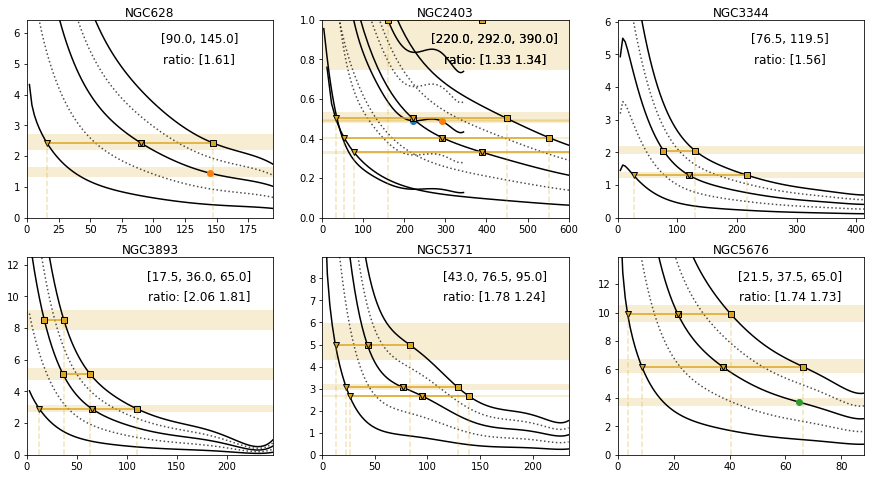

In [33]:
# d_path = './vel_curves/data/'
d_path = '/mnt/sdb2/science/spirals/CR_Olya/vel_curves/comb_vel_curves/'
ffnames = os.listdir(d_path)

vel_data = {}

fig, axes = plt.subplots(figsize=[15,8], ncols=3, nrows=2)
axes=axes.flatten()
ax_by_name = {'NGC628': axes[0],
 'NGC2403': axes[1],
 'NGC3344': axes[2],
 'NGC3893': axes[3],
 'NGC5371': axes[4],
 'NGC5676': axes[5]}


rings = {}

for fname in ffnames[2:]:
# for fname in ['NGC5676_WHISP_arcsec.data']:
    if '.png' in fname:
        continue
        
    if fname == 'Be87_NGC5371_kpc.data':
        continue
    
#     print('='*50)
#     print(fname)
    data = np.genfromtxt(d_path + fname, dtype=np.float, delimiter=',')
    if type(data[0])==np.float64:
        data = np.genfromtxt(d_path + fname, dtype=np.float, delimiter=' ')
    
    
   
    tmps = fname.replace('.data', '').replace('.dat', '').split('_')
    if len(tmps) == 2:
        name, units = tmps
        name2 = ''
    elif tmps[0].startswith('UGC') or tmps[0].startswith('NGC'):
        name, name2, units = tmps
    else:
        name2, name, units = tmps
    
    if name not in list(coords.keys()) and name2 not in coords.keys():
        continue
        
#     print(name, name2, units)
    if name  == 'NGC2403' and name2 != 'THINGS':
        data = np.genfromtxt(d_path + fname, dtype=np.float, delimiter='  ')
    
    if units == 'kpc':
        data[:,0] = data[:,0]/scales[name]
        units = 'arcsec'
    
    if units == 'arcmin':
        data[:,0] = data[:,0]*60.
        units = 'arcsec'
    
    
    #correct systemic velocity in several cases, ssee Appendix
    if name == 'UGC6263':
        data[:,1] = data[:,1]+58.
    if name == 'UGC6778':
        data[:,1] = data[:,1]+14.
    if name == 'UGC5557':
        data[:,1] = data[:,1]+13.
    if name == 'NGC0753':
        data[:,1] = data[:,1]+35.
    if name == 'NGC5676':
        data[:,1] = data[:,1]+40.
        tmp = '''0.8011099915759701, 59.92633091623861
                3.06734279248775, 140.62370955220433
                6.303166449183209, 147.6107100972896
                8.481855271634089, 167.24616375679295
                11.015675327464066, 184.58565269817154
                12.472539270907333, 200.74825324986375
                15.359838786937758, 214.63966568110868
                17.15201268561802, 214.6809600105713
                17.867230471911597, 213.5453659503478
                19.30096959085577, 213.57840141391785
                20.372970383706928, 211.298954427578
                22.520275515766173, 209.04428403891575
                23.955666407888856, 210.2294312944947
                26.11453395219769, 216.03954344989347
                28.996878148692616, 226.47462050511228
                31.152442146644404, 229.98050907649372
                34.01661683817579, 227.7423564196165
                35.452007730298504, 228.92750367519534
                37.9676582811648, 233.593762904478
                39.04131084719444, 232.46642771014683
                42.2721791843544, 235.99709287920587
                45.84661634264384, 229.1670107860789
                47.64704910721659, 234.9688640755851
                49.800961331989896, 237.32264085495774
                52.67174311623526, 239.69293536611553
                54.82400356783006, 240.89460035347952
                58.41330668472605, 244.433524388431
                60.917394823342846, 241.03500107365267
                64.49678730116779, 237.6612543565517
                65.2136568606399, 237.67777208833684
                67.00748253249861, 238.87117820980814
                70.95522042913063, 242.4183611106523
                72.38235245536083, 237.84294940618759
                74.52470226788455, 232.13194364149922
                77.3822698667019, 225.2853438165871
                80.60653111114777, 224.20756181761112
                82.39540146347105, 221.94463256305653
                83.8258370360582, 219.67344444260914
                85.61470738838142, 217.41051518805443
                88.1303579392478, 222.0767744173371'''
        
        tmp = [[float(_.split(',')[0]), float(_.split(',')[1])] for _ in tmp.split('\n')]
#         data = np.concatenate([data, np.array(tmp)])
        data = np.array(tmp) #we use Halpha rot map instead - this is correct, see Appendix notes (Valeria not get it perfectly accurate)
        
        
    if name == 'NGC7741':
        data[:,1] = data[:,1]+4.
    if name  == 'NGC628':
        tmp = '''4.94637079738348, 47.29018716149051
        14.743295929425287, 99.19343270602502
        25.245004376178798, 126.1217810431331
        35.170917518275175, 148.92721983210265
        44.86395743283603, 175.61210470105823
        54.56103172477478, 193.56760551858002
        64.84544412331299, 190.6702781815268
        74.89160412447846, 203.29157565970476
        84.71015800190736, 208.39562337294123
        94.98336379661806, 229.74658506764868
        105.04196312803208, 215.45228172057233
        124.91900427083672, 206.50450897705
        134.3910499579192, 211.3656535523253
        144.90833558399297, 204.58888013528613
        154.9577455002684, 210.1781737942535
        164.77618731165902, 215.52470439780757
        175.17770872019463, 209.23275667885574
        184.8829638329275, 209.48700650319222
        194.70925026699734, 197.85973478451382'''
        
        tmp = [[float(_.split(',')[0]), float(_.split(',')[1])] for _ in tmp.split('\n')]
        data = np.concatenate([data, np.array(tmp)]) 
        
    
    r25  = df[df['name'] == name]['r25'].values[0]
    
#     plt.plot(np.abs(data[:,0])/r25, np.abs(data[:,1]), 'o')
#     plt.ylim(0)
#     plt.title(name)
#     plt.xlabel(f'R, {units}')
    
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
    
    points = np.linspace(min(rad), max(rad), 100)
    velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    
#     line = plt.plot(points/r25, velocity_approx(points), label=name)
    
    dR = (max(rad) - min(rad)) / 20
    kappa = [epic_freq(velocity_approx, r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    ax = ax_by_name[name]
    
    
    ax.plot(points, omega, color='k')
    ax.plot(points, np.array(omega)-np.array(kappa)/2., color='k')
    ax.plot(points, np.array(omega)+np.array(kappa)/2., color='k')
    
    ax.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    ax.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    
    
    yli = -100
    
#     ke = name.replace('NGC', 'NGC ')
#     for ngckey in res[1].keys():
#         if name.replace('UGC', '') in res[1][ngckey]:
#             ke = ngckey
    cccrs = []        
    try:
        ke = reverse_spirals_set[name]
        print('ke:',ke)
#         info = info_by_galaxy[ke]
#         info = get_crs_points(ke)
#         info = df[df['altname']==ke][['cr', 'cr_l', 'cr_r', 'method']].values
        info = consist[ke]
        print(info)
        for info_ in info:
            try:
#                 cr,cr_l,cr_r,clr,method = info_

#                 cr,cr_l,cr_r,method = info_
#                 clr = method_color[method]
        
#                 cr = float(info_['cr'])
#                 method = info_['method']
#                 clr = method_color[method]

                cr_l,cr_r = info_
                cr = (cr_r+cr_l)/2.
                cccrs.append(cr)
                method = 'spirals'
                clr = method_color[method]

                omega_cr = velocity_approx(cr)/cr
                ax.plot([cr], [omega_cr], 'o')
                yli = max(yli, omega_cr+4)
            
#                 print(velocity_approx(cr_r)/cr_r, velocity_approx(cr_l)/cr_l)
            
                ax.axhspan(velocity_approx(cr_r)/cr_r, velocity_approx(cr_l)/cr_l, facecolor=clr, alpha=0.2)

                 
                xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-100, omega_cr], [1000, omega_cr]])

                intersection_line = shapely_line.intersection(hor_line)
#                 print('intersection_line1 ', intersection_line)
                
                if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                    y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                else:
                    y_new = intersection_line.xy[0][0]
                
                ax.plot([cr, y_new], [omega_cr, omega_cr], 's-', color=clr, mec='k')
                ax.plot([y_new, y_new], [0, omega_cr], '--', color=clr, alpha=0.3)


                xx,yy = np.array(omega)-np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-100, omega_cr], [1000, omega_cr]])

                intersection_line = shapely_line.intersection(hor_line)
#                 print('intersection_line2 ', intersection_line)
                
                if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                    y_new_ = [(pt.x, pt.y) for pt in intersection_line][0][0]
                else:
                    y_new_ = intersection_line.xy[0][0]
                
                if y_new_ < cr and y_new_ < y_new:
                    ax.plot([y_new_, cr], [omega_cr, omega_cr], 'v-', color=clr, mec='k')
                    ax.plot([y_new_, y_new_], [0, omega_cr], '--', color=clr, alpha=0.3)
            except Exception as e:
                print('++++++')
                print(e)
                
    except Exception as e:
        print('!!!!!+++')
        print(e)
        
    text = f'{cccrs}'
    rings[name] = cccrs
    
    ax.text(0.7, 0.9, text,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=12,
           color='k')
    
    ptmp = np.array(cccrs[1:])/np.array(cccrs[:-1])
    text = f'ratio: {np.array2string(ptmp, precision=2)}'
    
    ax.text(0.7, 0.8, text,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=12,
           color='k')
    
#     ax.set_ylabel(f'Omega, km/s/{units}', fontsize = 18)
#     ax.set_xlabel(f'Distance, {units}', fontsize = 18)
    ax.set_xlim(0, max(rad))
#     print(yli, np.max(np.array(omega)+np.array(kappa)/2.))
    if yli < 0:
        tmp = np.array(np.array(omega)+np.array(kappa)/2.)
        tmp = tmp[np.isfinite(tmp)]
        ax.set_ylim(0, np.max(tmp))
    else:
        tmp = np.array(omega)
        tmp_max = np.max(tmp[np.isfinite(tmp)])
        ax.set_ylim(0, min(yli, tmp_max+3))
    ax.set_title(name, pad=-40)
    if name == 'NGC2403':
        ax.set_xlim(0, 600)
        ax.set_ylim(0, 1)
# plt.xlabel('R/R25')
# plt.ylabel('V, km/s')
# plt.ylim(75,265)
# plt.xlim(0,2.05)
# plt.legend(fontsize=22, ncol=2)
# plt.yscale('log')

plt.savefig('omegas.png', bbox_inches='tight')
plt.show()

In [34]:
rings

{'NGC2403': [220.0, 292.0, 390.0],
 'NGC3344': [76.5, 119.5],
 'NGC3893': [17.5, 36.0, 65.0],
 'NGC5676': [21.5, 37.5, 65.0],
 'NGC628': [90.0, 145.0],
 'NGC5371': [43.0, 76.5, 95.0]}

In [35]:
# 0.262″/pix

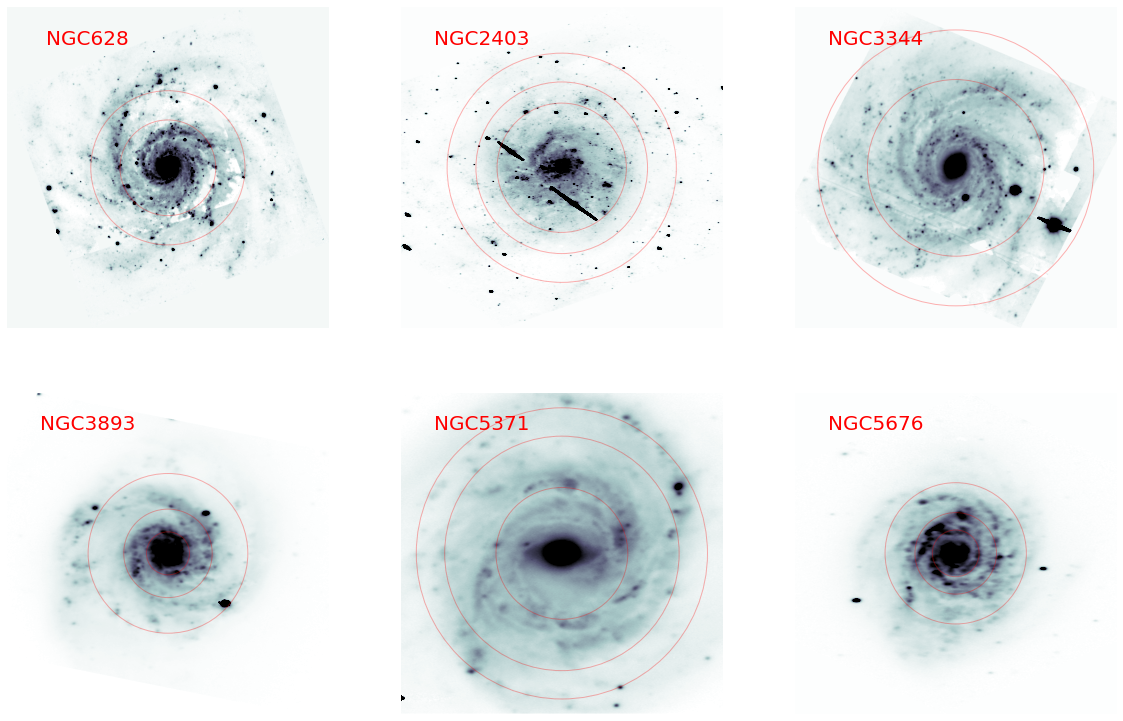

In [36]:
fig, axes = plt.subplots(figsize=[20,13], ncols=3, nrows=2)
axes = axes.flatten()

for ind, name in enumerate(coords.keys()):
    hdulist = pyfits.open(f'./fits/{name}_dr8_g_deproject.fits')
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data

    xl,yl = img_data_raw.shape
    x0,y0 = int(xl/2), int(yl/2)
    size = min(x0,y0)
    img_data_raw = img_data_raw[x0-size:x0+size, y0-size:y0+size]
    
    ax = axes[ind]
    lims = PercentileInterval(98.5).get_limits(img_data_raw)
    ax.imshow(img_data_raw, vmin=lims[0], vmax=lims[1], cmap=cm.bone_r)
    
    ax.text(0.25, 0.9, name,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=20,
           color='r')
    ax.axis('off')
    
    xl,yl = img_data_raw.shape
    x0,y0 = int(xl/2), int(yl/2)
    for cr in rings[name]:
        circle2 = plt.Circle((x0, y0), cr/0.262, color='r', fill=False, alpha=0.3)
        ax.add_patch(circle2)

plt.savefig('dataplot.png', bbox_inches='tight')
plt.show()

In [40]:
pts = [[],[]]
with open('/mnt/sdb2/science/spirals/crs_coupling/fits/NGC628_dr8_g_deproject.reg') as inpreg:
    lines = inpreg.readlines()[3:]
    for ll in lines:
        fl = ll.replace('point(', '').replace(') # point=cross', '').split(',')
        pts[0].append(float(fl[0]))
        pts[1].append(float(fl[1]))
    
pts = np.array(pts)

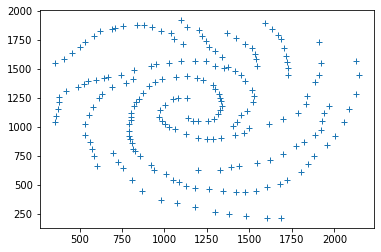

In [42]:
plt.plot(pts[0,:], pts[1,:], '+')

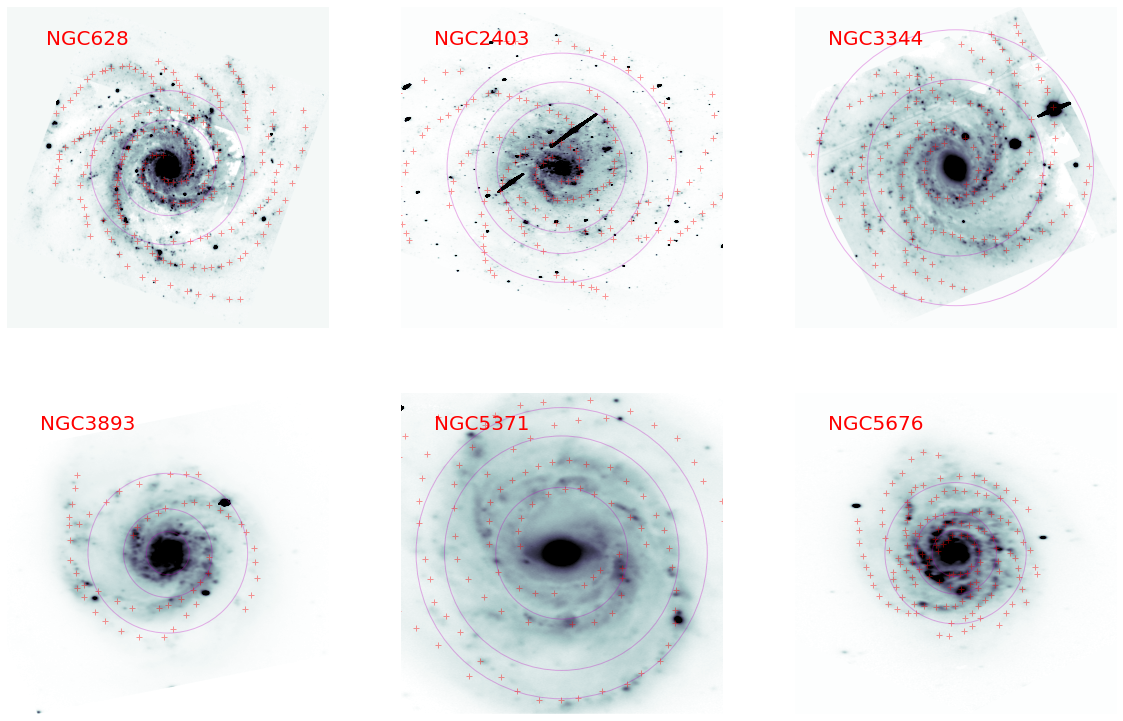

In [54]:
fig, axes = plt.subplots(figsize=[20,13], ncols=3, nrows=2)
axes = axes.flatten()

for ind, name in enumerate(coords.keys()):
    hdulist = pyfits.open(f'./fits/{name}_dr8_g_deproject.fits')
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data
    
    
    
    pts = [[],[]]
    with open(f'./fits/{name}_dr8_g_deproject.reg') as inpreg:
        lines = inpreg.readlines()[3:]
        for ll in lines:
            fl = ll.replace('point(', '').replace(') # point=cross', '').replace(') # point=x', '').split(',')
            pts[0].append(float(fl[0]))
            pts[1].append(float(fl[1]))

    pts = np.array(pts)
    
    xl,yl = img_data_raw.shape
    x0,y0 = int(xl/2), int(yl/2)
    size = min(x0,y0)
    img_data_raw_ = img_data_raw[x0-size:x0+size, y0-size:y0+size]
    
    ax = axes[ind]
    lims = PercentileInterval(98.5).get_limits(img_data_raw_)
    ax.imshow(img_data_raw, vmin=lims[0], vmax=lims[1], cmap=cm.bone_r)
    
    ax.plot(pts[0,:], pts[1,:], '+', color='r', alpha=0.4)
    
    ax.text(0.25, 0.9, name,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
           fontsize=20,
           color='r')
    ax.axis('off')
    
    xl,yl = img_data_raw.shape
    y0,x0 = int(xl/2), int(yl/2)
    for cr in rings[name]:
        circle2 = plt.Circle((x0, y0), cr/0.262, color='m', fill=False, alpha=0.3)
        ax.add_patch(circle2)
        
    ax.set_ylim(y0-size,y0+size)
    ax.set_xlim(x0-size,x0+size)

    
plt.savefig('dataplot.png', bbox_inches='tight')
plt.show()